In [1]:
from Bio import SeqIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
from tqdm.notebook import tqdm
import transformer_engine.pytorch as te
from transformer_engine.common import recipe
import faiss

[WARNING  | root               ]: Supported flash-attn versions are >= 2.1.1, <= 2.6.3. Found flash-attn 2.7.4.post1.


In [2]:
os.chdir('/root/autodl-tmp/evo2/evo2')
model_path = "/root/autodl-tmp/evo2/evo2_models/evo2_7b.pt"
from evo2.models import Evo2
from transformer_engine.common.recipe import _OverrideLinearPrecision

In [3]:
torch.cuda.empty_cache()

In [4]:
torch.serialization.add_safe_globals([_OverrideLinearPrecision])

In [5]:
evo2_model = Evo2(model_name='evo2_7b',local_path=model_path)

Loading model from /root/autodl-tmp/evo2/evo2_models/evo2_7b.pt...
Loading config from configs/evo2-7b-1m.yml...


100%|██████████| 32/32 [00:00<00:00, 148.43it/s]


Extra keys in state_dict: {'blocks.31.mixer.dense._extra_state', 'blocks.30.mixer.mixer.filter.t', 'blocks.16.mixer.mixer.filter.t', 'blocks.10.mixer.attn._extra_state', 'blocks.10.mixer.dense._extra_state', 'blocks.31.mixer.attn._extra_state', 'blocks.3.mixer.dense._extra_state', 'blocks.20.mixer.mixer.filter.t', 'blocks.13.mixer.mixer.filter.t', 'blocks.6.mixer.mixer.filter.t', 'blocks.17.mixer.dense._extra_state', 'unembed.weight', 'blocks.17.mixer.attn._extra_state', 'blocks.27.mixer.mixer.filter.t', 'blocks.3.mixer.attn._extra_state', 'blocks.23.mixer.mixer.filter.t', 'blocks.9.mixer.mixer.filter.t', 'blocks.24.mixer.attn._extra_state', 'blocks.24.mixer.dense._extra_state', 'blocks.2.mixer.mixer.filter.t'}


In [6]:
# sequence = 'ACGU'
# input_ids = torch.tensor(
#     model.tokenizer.tokenize(sequence),
#     dtype=torch.int,
# ).unsqueeze(0).to('cuda:0')

# layer_name = 'blocks.28.mlp.l3'

# outputs, embeddings = model(input_ids, return_embeddings=True, layer_names=[layer_name])

# print('Embeddings shape: ', embeddings[layer_name].shape)

In [7]:
# outputs

In [8]:
# embeddings

In [9]:
import time
import gc
import os
from Bio import SeqIO

In [22]:
# --- 配置参数 ---
N_PAIRS = 1000  # 取前100对序列
LAYER_NAME = 'blocks.28.mlp.l3'  # 使用的模型层
DEVICE = 'cuda:0'  # 使用GPU
BATCH_SIZE = 1  # 使用最小的批量大小
MAX_SEQ_LENGTH = 40000  # 限制序列最大长度

# --- 文件路径 ---
os.chdir('/root/autodl-tmp/evo2/notebooks/')
homology_human_fasta = "human_homology_lncRNAs.fa"
homology_mouse_fasta = "mouse_homology_lncRNAs.fa"
syntenic_human_fasta = "human_syntenic_not_homology_lncRNAs.fa"
syntenic_mouse_fasta = "mouse_syntenic_not_homology_lncRNAs.fa"

HIDDEN_SIZE = 4096

In [23]:
# --- 函数：从FASTA文件中按顺序选择序列对 ---
def get_sequence_pairs(human_fasta, mouse_fasta, n_pairs):
    """从一对FASTA文件中按顺序选择指定数量的序列对"""
    human_records = list(SeqIO.parse(human_fasta, "fasta"))
    mouse_records = list(SeqIO.parse(mouse_fasta, "fasta"))
    
    # 确保两个文件有相同数量的序列
    min_len = min(len(human_records), len(mouse_records))
    if min_len < n_pairs:
        print(f"警告: 文件对只有 {min_len} 对序列，少于请求的 {n_pairs} 对")
        n_pairs = min_len
    
    # 按顺序选择前n_pairs对序列
    human_samples = human_records[:n_pairs]
    mouse_samples = mouse_records[:n_pairs]
    
    return human_samples, mouse_samples

In [12]:
df = get_sequence_pairs(homology_human_fasta, homology_mouse_fasta, 5)

In [13]:
df[0]

[SeqRecord(seq=Seq('CCCTGCTCAACAGCGTGCTCCTGGTGATACTGCCACCCGTAACGGGTACTGGCT...ATA'), id='ENST00000413591.1|ENSG00000224511.1|OTTHUMG00000016663.2|OTTHUMT00000125960.1|LINC00365-002|LINC00365|2618||ENSMUST00000133694|0|0|0|0|0|0|4.928|27.14', name='ENST00000413591.1|ENSG00000224511.1|OTTHUMG00000016663.2|OTTHUMT00000125960.1|LINC00365-002|LINC00365|2618||ENSMUST00000133694|0|0|0|0|0|0|4.928|27.14', description='ENST00000413591.1|ENSG00000224511.1|OTTHUMG00000016663.2|OTTHUMT00000125960.1|LINC00365-002|LINC00365|2618||ENSMUST00000133694|0|0|0|0|0|0|4.928|27.14', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTAAAATGAGACAGGTTATAACCTGCTTTAAACTTGACAGCTTTCTAAAGCTG...TCC'), id='ENST00000454305.1|ENSG00000230498.1|OTTHUMG00000009688.1|OTTHUMT00000026695.1|RP4-564M11.2-001|RP4-564M11.2|497||ENSMUST00000198047|1|0|0|0|1|0|5.306|43.158', name='ENST00000454305.1|ENSG00000230498.1|OTTHUMG00000009688.1|OTTHUMT00000026695.1|RP4-564M11.2-001|RP4-564M11.2|497||ENSMUST00000198047|1|0|0|0|1|0|5.306|43.158', descripti

In [24]:
# --- 函数：处理序列并获取嵌入 ---
def get_embeddings(sequences, batch_size=BATCH_SIZE):
    """批量处理序列并获取嵌入向量"""
    all_embeddings = []
    
    # 分批处理序列
    for i in tqdm(range(0, len(sequences), batch_size), desc="处理序列"):
        batch_sequences = sequences[i:i+batch_size]
        batch_embeddings = []
        
        # 处理批次中的每个序列
        for record in batch_sequences:
            sequence = str(record.seq)
            
            # 限制序列长度
            if len(sequence) > MAX_SEQ_LENGTH:
                sequence = sequence[:MAX_SEQ_LENGTH]
                print(f"警告: 序列长度超过限制，已截断为 {MAX_SEQ_LENGTH} 个字符")
            
            # 使用模型的分词器处理序列
            try:
                input_ids = torch.tensor(
                    evo2_model.tokenizer.tokenize(sequence),
                    dtype=torch.int,
                ).unsqueeze(0).to(DEVICE)
                
                # 获取嵌入
                with torch.no_grad():  # 不计算梯度，节省显存
                    _, embeddings = evo2_model(input_ids, return_embeddings=True, layer_names=[LAYER_NAME])
                
                # 应用均值池化并转换为float32
                pooled_embedding = torch.mean(embeddings[LAYER_NAME], dim=1).squeeze()
                pooled_embedding = pooled_embedding.to(torch.float32).cpu().numpy()  # 转换为float32
                
                # 检查嵌入是否有效
                if np.any(np.isnan(pooled_embedding)) or np.any(np.isinf(pooled_embedding)):
                    print("警告: 嵌入包含NaN或inf值，使用零向量代替")
                    pooled_embedding = np.zeros(HIDDEN_SIZE, dtype=np.float32)
                
                batch_embeddings.append(pooled_embedding)
                
                # 清理显存
                del input_ids, embeddings
                torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"处理序列时出错: {e}")
                # 添加一个零向量作为占位符
                batch_embeddings.append(np.zeros(HIDDEN_SIZE, dtype=np.float32))
        
        all_embeddings.extend(batch_embeddings)
        
        # 清理内存
        gc.collect()
    
    return np.array(all_embeddings)

# --- 主处理流程 ---
def process_dataset(human_fasta, mouse_fasta, dataset_name):
    """处理一个完整的数据集（人类和小鼠序列对）"""
    print(f"\n处理 {dataset_name} 数据集...")
    
    # 按顺序选择人类和小鼠序列对
    human_records, mouse_records = get_sequence_pairs(human_fasta, mouse_fasta, N_PAIRS)
    
    print(f"选择了 {len(human_records)} 对人类-小鼠序列对")
    
    # 获取人类序列嵌入
    print("获取人类序列嵌入...")
    human_embeddings = get_embeddings(human_records)
    
    # 强制清理显存
    torch.cuda.empty_cache()
    gc.collect()
    
    # 获取小鼠序列嵌入
    print("获取小鼠序列嵌入...")
    mouse_embeddings = get_embeddings(mouse_records)
    
    return human_embeddings, mouse_embeddings, human_records, mouse_records

# --- 处理同源数据集 ---
homology_human_emb, homology_mouse_emb, homology_human_records, homology_mouse_records = process_dataset(
    homology_human_fasta, homology_mouse_fasta, "同源"
)

# 处理完一个数据集后清理显存
torch.cuda.empty_cache()
gc.collect()

# --- 处理非同源共线数据集 ---
syntenic_human_emb, syntenic_mouse_emb, syntenic_human_records, syntenic_mouse_records = process_dataset(
    syntenic_human_fasta, syntenic_mouse_fasta, "非同源共线"
)

# 处理完所有数据集后清理显存
torch.cuda.empty_cache()
gc.collect()

# --- 使用FAISS计算相似性 ---
print("\n使用FAISS计算相似性...")

# 确保所有嵌入都是float32类型且没有NaN或inf值
def prepare_embeddings(embeddings):
    embeddings = np.array(embeddings, dtype=np.float32)
    # # 替换NaN和inf值为0
    # embeddings = np.nan_to_num(embeddings, nan=0.0, posinf=0.0, neginf=0.0)
    return embeddings

homology_human_emb = prepare_embeddings(homology_human_emb)
homology_mouse_emb = prepare_embeddings(homology_mouse_emb)
syntenic_human_emb = prepare_embeddings(syntenic_human_emb)
syntenic_mouse_emb = prepare_embeddings(syntenic_mouse_emb)

# 创建FAISS索引
def create_faiss_index(embeddings):
    """创建FAISS索引"""
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # 使用内积作为相似度度量
    # 确保嵌入是C连续的
    embeddings = np.ascontiguousarray(embeddings, dtype=np.float32)
    # 归一化向量以便内积等于余弦相似度
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    return index

# 为人类和小鼠序列创建索引
homology_human_index = create_faiss_index(homology_human_emb)
homology_mouse_index = create_faiss_index(homology_mouse_emb)
syntenic_human_index = create_faiss_index(syntenic_human_emb)
syntenic_mouse_index = create_faiss_index(syntenic_mouse_emb)

# --- 计算对应序列对的相似性 ---
def calculate_pairwise_similarity(embeddings1, embeddings2):
    """
    计算两个嵌入集合中对应位置向量的相似性
    假设embeddings1和embeddings2已经按对应关系排序
    """
    # 确保两个嵌入集合的大小相同
    assert len(embeddings1) == len(embeddings2), "嵌入集合大小不一致"
    
    # 确保嵌入是C连续的
    embeddings1 = np.ascontiguousarray(embeddings1, dtype=np.float32)
    embeddings2 = np.ascontiguousarray(embeddings2, dtype=np.float32)
    
    # 归一化向量
    faiss.normalize_L2(embeddings1)
    faiss.normalize_L2(embeddings2)
    
    # 计算每对向量的内积（即余弦相似度）
    similarities = np.sum(embeddings1 * embeddings2, axis=1)
    
    return similarities

# --- 计算同源数据集内部的人类-小鼠对应序列对相似性 ---
print("计算同源数据集内部的人类-小鼠对应序列对相似性...")
homology_pairwise_similarities = calculate_pairwise_similarity(
    homology_human_emb, homology_mouse_emb
)

# --- 计算非同源共线数据集内部的人类-小鼠对应序列对相似性 ---
print("计算非同源共线数据集内部的人类-小鼠对应序列对相似性...")
syntenic_pairwise_similarities = calculate_pairwise_similarity(
    syntenic_human_emb, syntenic_mouse_emb
)

# --- 输出结果 ---
print("\n=== 结果摘要 ===")
print(f"同源数据集:")
print(f"  人类-小鼠对应序列对平均相似度: {np.mean(homology_pairwise_similarities):.4f}")
print(f"  人类-小鼠对应序列对相似度标准差: {np.std(homology_pairwise_similarities):.4f}")
print(f"  人类-小鼠对应序列对数量: {len(homology_pairwise_similarities)}")

print(f"\n非同源共线数据集:")
print(f"  人类-小鼠对应序列对平均相似度: {np.mean(syntenic_pairwise_similarities):.4f}")
print(f"  人类-小鼠对应序列对相似度标准差: {np.std(syntenic_pairwise_similarities):.4f}")
print(f"  人类-小鼠对应序列对数量: {len(syntenic_pairwise_similarities)}")

# --- 保存结果 ---
np.savez("pairwise_similarity_results.npz",
         homology_pairwise_similarities=homology_pairwise_similarities,
         syntenic_pairwise_similarities=syntenic_pairwise_similarities,
         homology_human_emb=homology_human_emb,
         homology_mouse_emb=homology_mouse_emb,
         syntenic_human_emb=syntenic_human_emb,
         syntenic_mouse_emb=syntenic_mouse_emb)

print("\n结果已保存到 pairwise_similarity_results.npz")


处理 同源 数据集...
选择了 1000 对人类-小鼠序列对
获取人类序列嵌入...


处理序列:   0%|          | 0/1000 [00:00<?, ?it/s]

警告: 序列长度超过限制，已截断为 40000 个字符
处理序列时出错: CUDA out of memory. Tried to allocate 9.77 GiB. GPU 0 has a total capacity of 31.36 GiB of which 3.79 GiB is free. Including non-PyTorch memory, this process has 27.56 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
警告: 序列长度超过限制，已截断为 40000 个字符
处理序列时出错: CUDA out of memory. Tried to allocate 9.77 GiB. GPU 0 has a total capacity of 31.36 GiB of which 3.70 GiB is free. Including non-PyTorch memory, this process has 27.65 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expan

处理序列:   0%|          | 0/1000 [00:00<?, ?it/s]

处理序列时出错: CUDA out of memory. Tried to allocate 4.74 GiB. GPU 0 has a total capacity of 31.36 GiB of which 4.67 GiB is free. Including non-PyTorch memory, this process has 26.68 GiB memory in use. Of the allocated memory 17.77 GiB is allocated by PyTorch, and 7.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
警告: 序列长度超过限制，已截断为 40000 个字符
处理序列时出错: CUDA out of memory. Tried to allocate 9.77 GiB. GPU 0 has a total capacity of 31.36 GiB of which 3.40 GiB is free. Including non-PyTorch memory, this process has 27.95 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid

处理序列:   0%|          | 0/1000 [00:00<?, ?it/s]

警告: 序列长度超过限制，已截断为 40000 个字符
处理序列时出错: CUDA out of memory. Tried to allocate 9.77 GiB. GPU 0 has a total capacity of 31.36 GiB of which 3.31 GiB is free. Including non-PyTorch memory, this process has 28.04 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
获取小鼠序列嵌入...


处理序列:   0%|          | 0/1000 [00:00<?, ?it/s]


使用FAISS计算相似性...
计算同源数据集内部的人类-小鼠对应序列对相似性...
计算非同源共线数据集内部的人类-小鼠对应序列对相似性...

=== 结果摘要 ===
同源数据集:
  人类-小鼠对应序列对平均相似度: 0.9599
  人类-小鼠对应序列对相似度标准差: 0.0733
  人类-小鼠对应序列对数量: 1000

非同源共线数据集:
  人类-小鼠对应序列对平均相似度: 0.9581
  人类-小鼠对应序列对相似度标准差: 0.0572
  人类-小鼠对应序列对数量: 1000

结果已保存到 pairwise_similarity_results.npz


In [30]:
# homology_pairwise_similarities
# syntenic_pairwise_similarities

In [26]:
# --- 可视化部分（可选） ---
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.sans-serif"] = "Noto Sans CJK JP"
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 设置绘图风格
    sns.set(style="whitegrid")
    
    # 创建对比图
    plt.figure(figsize=(10, 6))
    
    # 同源数据集相似度分布
    sns.kdeplot(homology_similarities[:, 0], label="同源对", shade=True)
    
    # 非同源共线数据集相似度分布
    sns.kdeplot(syntenic_similarities[:, 0], label="非同源共线对", shade=True)
    
    plt.title("人类-小鼠lncRNA序列相似度分布")
    plt.xlabel("余弦相似度")
    plt.ylabel("密度")
    plt.legend()
    plt.savefig("similarity_distribution.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("相似度分布图已保存到 similarity_distribution.png")
    
except ImportError:
    print("未安装matplotlib或seaborn，跳过可视化部分")

print("\n处理完成!")

NameError: name 'homology_similarities' is not defined

<Figure size 1000x600 with 0 Axes>

In [21]:
from scipy import stats

# 统计检验
t_stat, p_value = stats.ttest_ind(homology_pairwise_similarities[:, 0], syntenic_pairwise_similarities[:, 0])
print(f"t检验结果: t={t_stat:.4f}, p={p_value:.4e}")

if p_value < 0.05:
    print("差异 statistically significant")
else:
    print("差异 not statistically significant")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
from Bio import SeqIO
import numpy as np
import statistics

def analyze_fasta_stats(file_path):
    """
    分析FASTA文件的序列长度统计信息
    """
    # 读取序列并获取长度
    lengths = []
    for record in SeqIO.parse(file_path, "fasta"):
        lengths.append(len(record.seq))
    
    # 计算统计量
    stats = {
        'total_sequences': len(lengths),
        'total_bases': sum(lengths),
        'max_length': max(lengths),
        'min_length': min(lengths),
        'mean_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'std_dev': np.std(lengths),
        'n50': calculate_n50(lengths) if lengths else 0
    }
    
    return stats, lengths

def calculate_n50(lengths):
    """计算N50统计量"""
    sorted_lengths = sorted(lengths, reverse=True)
    total = sum(lengths)
    half_total = total / 2
    cumulative = 0
    for length in sorted_lengths:
        cumulative += length
        if cumulative >= half_total:
            return length
    return 0

# 使用示例
if __name__ == "__main__":
    file_path = "mouse_homology_lncRNAs.fa"  # 替换为你的FASTA文件路径
    
    stats, all_lengths = analyze_fasta_stats(file_path)
    
    # 打印统计结果
    print("FASTA文件序列统计信息:")
    print(f"总序列数: {stats['total_sequences']}")
    print(f"总碱基数: {stats['total_bases']}")
    print(f"最大长度: {stats['max_length']}")
    print(f"最小长度: {stats['min_length']}")
    print(f"平均长度: {stats['mean_length']:.2f}")
    print(f"中位数长度: {stats['median_length']}")
    print(f"标准差: {stats['std_dev']:.2f}")
    print(f"N50: {stats['n50']}")
    
    # 可选：打印长度分布
    print(f"\n长度分布示例（前10个）: {all_lengths[:10]}")


In [27]:
import pandas as pd
from Bio import SeqIO
import os

def process_fasta_pairs(human_fasta, mouse_fasta, pair_type, max_pairs=100):
    """
    处理一对人类和小鼠FASTA文件，提取序列信息
    
    参数:
    human_fasta: 人类FASTA文件路径
    mouse_fasta: 小鼠FASTA文件路径  
    pair_type: 对类型 ('homology' 或 'syntenic')
    max_pairs: 最大提取的对数
    
    返回:
    包含序列信息的DataFrame
    """
    # 读取人类和小鼠序列
    human_records = list(SeqIO.parse(human_fasta, "fasta"))
    mouse_records = list(SeqIO.parse(mouse_fasta, "fasta"))
    
    # 确定实际可用的对数
    actual_pairs = min(len(human_records), len(mouse_records), max_pairs)
    
    print(f"处理 {pair_type} 对: 找到 {actual_pairs} 对序列")
    
    # 收集序列信息
    data = []
    for i in range(actual_pairs):
        human_record = human_records[i]
        mouse_record = mouse_records[i]
        
        data.append({
            "Pair_Type": pair_type,
            "Pair_Index": i + 1,
            "Human_Sequence_ID": human_record.id,
            "Human_Sequence_Length": len(human_record.seq),
            "Human_Sequence": str(human_record.seq),
            "Mouse_Sequence_ID": mouse_record.id, 
            "Mouse_Sequence_Length": len(mouse_record.seq),
            "Mouse_Sequence": str(mouse_record.seq)
        })
    
    return pd.DataFrame(data)

# 文件路径
homology_human_fasta = "human_homology_lncRNAs.fa"
homology_mouse_fasta = "mouse_homology_lncRNAs.fa"
syntenic_human_fasta = "human_syntenic_not_homology_lncRNAs.fa"
syntenic_mouse_fasta = "mouse_syntenic_not_homology_lncRNAs.fa"

# 检查文件是否存在
for file_path in [homology_human_fasta, homology_mouse_fasta, 
                  syntenic_human_fasta, syntenic_mouse_fasta]:
    if not os.path.exists(file_path):
        print(f"警告: 文件 {file_path} 不存在")
        # 这里可以根据需要处理文件不存在的情况

# 处理同源对
homology_df = process_fasta_pairs(
    homology_human_fasta, homology_mouse_fasta, "homology", max_pairs=100
)

# 处理共线不同源对
syntenic_df = process_fasta_pairs(
    syntenic_human_fasta, syntenic_mouse_fasta, "syntenic", max_pairs=100
)

# 合并两个DataFrame
combined_df = pd.concat([homology_df, syntenic_df], ignore_index=True)

# 创建Excel写入器
output_file = "sequence_pairs.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # 写入完整数据
    combined_df.to_excel(writer, sheet_name='All_Sequence_Pairs', index=False)
    
    # 为同源和共线不同源对创建单独的工作表
    homology_df.to_excel(writer, sheet_name='Homology_Pairs', index=False)
    syntenic_df.to_excel(writer, sheet_name='Syntenic_Pairs', index=False)
    
    # 创建摘要工作表
    summary_data = {
        'Pair_Type': ['Homology', 'Syntenic'],
        'Number_of_Pairs': [len(homology_df), len(syntenic_df)],
        'Average_Human_Length': [
            homology_df['Human_Sequence_Length'].mean(),
            syntenic_df['Human_Sequence_Length'].mean()
        ],
        'Average_Mouse_Length': [
            homology_df['Mouse_Sequence_Length'].mean(),
            syntenic_df['Mouse_Sequence_Length'].mean()
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"结果已保存到 {output_file}")
print(f"同源对数量: {len(homology_df)}")
print(f"共线不同源对数量: {len(syntenic_df)}")

处理 homology 对: 找到 100 对序列
处理 syntenic 对: 找到 100 对序列
结果已保存到 sequence_pairs.xlsx
同源对数量: 100
共线不同源对数量: 100


In [29]:
LAYER_NAME = 'blocks.28.mlp.l3'
BATCH_SIZE = 8  # 根据GPU内存调整批次大小

def get_sequence_embeddings(sequences, batch_size=BATCH_SIZE):
    """批量处理序列并获取嵌入向量"""
    all_embeddings = []
    
    # 分批处理序列
    for i in tqdm(range(0, len(sequences), batch_size), desc="处理序列"):
        batch_sequences = sequences[i:i+batch_size]
        batch_embeddings = []
        
        # 处理批次中的每个序列
        for sequence in batch_sequences:
            # 使用模型的分词器处理序列
            try:
                input_ids = torch.tensor(
                    evo2_model.tokenizer.tokenize(sequence),
                    dtype=torch.int,
                ).unsqueeze(0).to(DEVICE)
                
                # 获取嵌入
                with torch.no_grad():  # 不计算梯度，节省显存
                    _, embeddings = evo2_model(input_ids, return_embeddings=True, layer_names=[LAYER_NAME])
                
                # 应用均值池化并转换为numpy数组
                pooled_embedding = torch.mean(embeddings[LAYER_NAME], dim=1).squeeze()
                pooled_embedding = pooled_embedding.to(torch.float32).cpu().numpy()
                batch_embeddings.append(pooled_embedding)
                
                # 清理显存
                del input_ids, embeddings
                torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"处理序列时出错: {e}")
                # 添加一个零向量作为占位符
                batch_embeddings.append(np.zeros(evo2_model.embedding_dim, dtype=np.float32))
        
        all_embeddings.extend(batch_embeddings)
        
        # 清理内存
        gc.collect()
    
    return np.array(all_embeddings)

def calculate_pairwise_similarity(embeddings1, embeddings2):
    """
    计算两个嵌入集合中对应位置向量的相似性
    假设embeddings1和embeddings2已经按对应关系排序
    """
    # 确保两个嵌入集合的大小相同
    assert len(embeddings1) == len(embeddings2), "嵌入集合大小不一致"
    
    # 确保嵌入是C连续的
    embeddings1 = np.ascontiguousarray(embeddings1, dtype=np.float32)
    embeddings2 = np.ascontiguousarray(embeddings2, dtype=np.float32)
    
    # 归一化向量
    faiss.normalize_L2(embeddings1)
    faiss.normalize_L2(embeddings2)
    
    # 计算每对向量的内积（即余弦相似度）
    similarities = np.sum(embeddings1 * embeddings2, axis=1)
    
    return similarities

# 读取Excel文件
df = pd.read_excel("sequence_pairs.xlsx")

# 分离同源对和共线不同源对
homology_df = df[df['Pair_Type'] == 'homology'].head(100)
syntenic_df = df[df['Pair_Type'] == 'syntenic'].head(100)

print(f"同源对数量: {len(homology_df)}")
print(f"共线不同源对数量: {len(syntenic_df)}")

# 获取序列
homology_human_sequences = homology_df['Human_Sequence'].tolist()
homology_mouse_sequences = homology_df['Mouse_Sequence'].tolist()
syntenic_human_sequences = syntenic_df['Human_Sequence'].tolist()
syntenic_mouse_sequences = syntenic_df['Mouse_Sequence'].tolist()

# 获取嵌入向量
print("获取同源人类序列嵌入...")
homology_human_emb = get_sequence_embeddings(homology_human_sequences)

print("获取同源小鼠序列嵌入...")
homology_mouse_emb = get_sequence_embeddings(homology_mouse_sequences)

print("获取共线不同源人类序列嵌入...")
syntenic_human_emb = get_sequence_embeddings(syntenic_human_sequences)

print("获取共线不同源小鼠序列嵌入...")
syntenic_mouse_emb = get_sequence_embeddings(syntenic_mouse_sequences)

# 计算相似度
print("计算同源对相似度...")
homology_similarities = calculate_pairwise_similarity(homology_human_emb, homology_mouse_emb)

print("计算共线不同源对相似度...")
syntenic_similarities = calculate_pairwise_similarity(syntenic_human_emb, syntenic_mouse_emb)

# 将相似度结果添加到DataFrame
homology_df['Similarity'] = homology_similarities
syntenic_df['Similarity'] = syntenic_similarities

# 合并结果
result_df = pd.concat([homology_df, syntenic_df], ignore_index=True)

# 保存结果
output_file = "sequence_similarity_results.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    result_df.to_excel(writer, sheet_name='Sequence_Similarities', index=False)
    
    # 创建摘要工作表
    summary_data = {
        'Pair_Type': ['Homology', 'Syntenic'],
        'Number_of_Pairs': [len(homology_df), len(syntenic_df)],
        'Average_Similarity': [
            homology_df['Similarity'].mean(),
            syntenic_df['Similarity'].mean()
        ],
        'Std_Similarity': [
            homology_df['Similarity'].std(),
            syntenic_df['Similarity'].std()
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"结果已保存到 {output_file}")
print(f"同源对平均相似度: {homology_df['Similarity'].mean():.4f}")
print(f"共线不同源对平均相似度: {syntenic_df['Similarity'].mean():.4f}")

同源对数量: 100
共线不同源对数量: 100
获取同源人类序列嵌入...


处理序列:   0%|          | 0/13 [00:00<?, ?it/s]

获取同源小鼠序列嵌入...


处理序列:   0%|          | 0/13 [00:00<?, ?it/s]

获取共线不同源人类序列嵌入...


处理序列:   0%|          | 0/13 [00:00<?, ?it/s]

获取共线不同源小鼠序列嵌入...


处理序列:   0%|          | 0/13 [00:00<?, ?it/s]

计算同源对相似度...
计算共线不同源对相似度...
结果已保存到 sequence_similarity_results.xlsx
同源对平均相似度: 0.9667
共线不同源对平均相似度: 0.9520


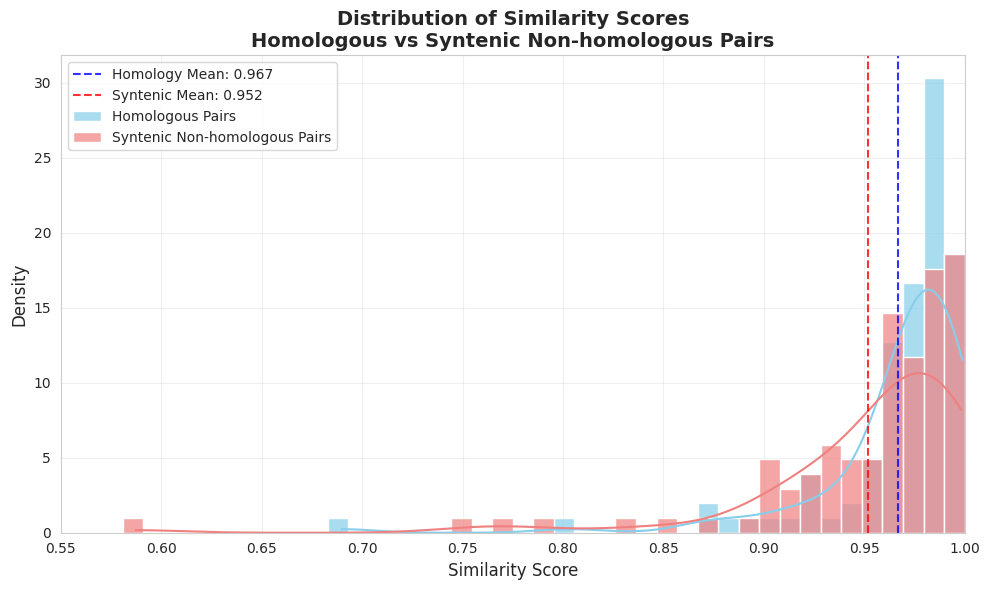

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置中文字体支持（确保系统中有中文字体）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取Excel文件
df = pd.read_excel("sequence_similarity_results.xlsx")

# 分离同源对和共线不同源对
homology_df = df[df['Pair_Type'] == 'homology']
syntenic_df = df[df['Pair_Type'] == 'syntenic']

# 创建图表
plt.figure(figsize=(10, 6))

# 设置样式
sns.set_style("whitegrid")
sns.set_palette("pastel")

# 计算统一的bin宽度和位置
all_data = pd.concat([homology_df['Similarity'], syntenic_df['Similarity']])
bins = np.linspace(0.55, 1.00, 45)  # 在0.55到1.00之间创建30个等间距的bin

# 绘制分布图，使用相同的bin设置
sns.histplot(data=homology_df, x='Similarity', label='Homologous Pairs', 
             alpha=0.7, kde=True, stat='density', color='skyblue', bins=bins)
sns.histplot(data=syntenic_df, x='Similarity', label='Syntenic Non-homologous Pairs', 
             alpha=0.7, kde=True, stat='density', color='lightcoral', bins=bins)

# 添加均值和标注
homology_mean = homology_df['Similarity'].mean()
syntenic_mean = syntenic_df['Similarity'].mean()

plt.axvline(homology_mean, color='blue', linestyle='--', alpha=0.8, 
            label=f'Homology Mean: {homology_mean:.3f}')
plt.axvline(syntenic_mean, color='red', linestyle='--', alpha=0.8, 
            label=f'Syntenic Mean: {syntenic_mean:.3f}')

# 设置标题和标签
plt.title('Distribution of Similarity Scores\nHomologous vs Syntenic Non-homologous Pairs', 
          fontsize=14, fontweight='bold')
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)

# 设置图例
plt.legend(loc='upper left', fontsize=10)

# 设置x轴范围
plt.xlim(0.55, 1.00)

# 添加网格
plt.grid(True, alpha=0.3)

# # 添加文本标注
# plt.text(0.86, plt.ylim()[1]*0.9, 
#          f'Homologous Pairs (n={len(homology_df)})\nSyntenic Pairs (n={len(syntenic_df)})', 
#          bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 保存图像
plt.savefig('similarity_distribution.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()